# Meat Elasticity Modelling

## Auth and package setup

In [194]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np
import sys
import os
import plotnine as p9
from mizani.formatters import currency_format

In [196]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


## Get data

In [197]:
# def bq_sql_mainData(lagDays=7):
#     query = """
#     #standardSQL
#     create temp table elastData_meat as (
#     with asp_dat as
#     (
#     SELECT
#     ifnull(SalesOrg,'') as SalesOrg,
#     ifnull(Site,'') as Site,
#     ifnull(Article,'') as Article,
#     ifnull(Article_Description,'') as Article_Description,
#     ifnull(Category_Description,'') as Category_Description,
#     ifnull(SubCategory_Description,'') as SubCategory_Description,
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
#     , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
#     , sum(Sales_ExclTax) as Sales_ExclTax
#     , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
#     , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     , sum(Promo_Sales) as Promo_Sales
#     , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
#     FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
#     WHERE
#     SalesOrg in ('1005') AND
#     Category_Description in ("MEAT","MEAT CONVENIENCE") AND
#     Calendar_Day between '2018-01-01' AND '2020-12-16'
#     group by ifnull(SalesOrg,''),
#     ifnull(Site,''),
#     ifnull(Article,''),
#     ifnull(Article_Description,''),
#     ifnull(Category_Description,''),
#     ifnull(SubCategory_Description,''),
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
#     )
#     select a.*,
#     a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
#     a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
#     b.Sales_ExclTax as Sales_ExclTax_lag,
#     b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
#     b.ASP as ASP_lag,
#     a.ASP-b.ASP as ASP_diff,
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
#     log(case when b.ASP = 0 then null
#     when a.ASP/b.ASP < 0 then null
#     else a.ASP/b.ASP end) as log_ASP_v_lag,
#     log(case when b.Sales_Qty_SUoM = 0 then null
#     when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
#     else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
#     (case when a.Sales_ExclTax = 0 then 0
#     when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
#     else a.Promo_Sales/a.Sales_ExclTax
#     end) as promo_perc
#     from asp_dat a
#     left join (
#     SELECT *
#     from asp_dat
#     ) b
#     on (a.lag_Calendar_Day=b.Calendar_Day) AND
#     (a.SalesOrg = b.SalesOrg) and
#     (a.Site = b.Site) and
#     (a.Article=b.Article) AND
#     (a.Sales_Unit=b.Sales_Unit)
#     where
#     b.Sales_Qty_SUoM > 0 AND
#     b.Sales_Qty_SUoM is not null AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
#     );

#     with dat as (
#     SELECT a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end) as covid_flag,
#     avg(a.log_ASP_v_lag) as mean_x,
#     avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
#     corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
#     stddev(a.log_ASP_v_lag) as sd_x,
#     stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
#     sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
#     sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
#     avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
#     sum(Sales_ExclTax) as Sales_ExclTax,
#     sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
#     (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     FROM elastData_meat a
#     group by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end)
#     )
#     select a.*,
#     a.corr_xy*a.sd_y/a.sd_x as slope,
#     a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
#     from dat a
#     #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
#     where ifnull(a.cnt_overs,0)>50 and ifnull(a.cnt_unders,0)>50
#     order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
#     """.format(lagDays=lagDays)
#     return query

# def run_bq(sql, client, location="US"):
#     query_job = client.query(sql, location=location)
#     # wait for query to run_bq
#     query_job.result()

# def get_bq_data(sql, project_id):
#     import pandas_gbq
#     return pandas_gbq.read_gbq(sql,
#                                project_id=project_id,
#                                use_bqstorage_api=True)


In [198]:
# def bq_sql_mainData(lagDays=7):
#     query = """
#     #standardSQL
#     create temp table elastData_meat as (
#     with asp_dat as
#     (
#     SELECT
#     ifnull(SalesOrg,'') as SalesOrg,
#     ifnull(Site,'') as Site,
#     ifnull(Article,'') as Article,
#     ifnull(Article_Description,'') as Article_Description,
#     ifnull(Category_Description,'') as Category_Description,
#     ifnull(SubCategory_Description,'') as SubCategory_Description,
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
#     , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
#     , sum(Sales_ExclTax) as Sales_ExclTax
#     , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
#     , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     , sum(Promo_Sales) as Promo_Sales
#     , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
#     FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
#     WHERE
#     SalesOrg in ('1005') AND
#     Category_Description in ("MEAT","MEAT CONVENIENCE") AND
#     Calendar_Day between '2018-01-01' AND '2020-12-16'
#     group by ifnull(SalesOrg,''),
#     ifnull(Site,''),
#     ifnull(Article,''),
#     ifnull(Article_Description,''),
#     ifnull(Category_Description,''),
#     ifnull(SubCategory_Description,''),
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
#     )
#     select a.*,
#     a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
#     a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
#     b.Sales_ExclTax as Sales_ExclTax_lag,
#     b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
#     b.ASP as ASP_lag,
#     a.ASP-b.ASP as ASP_diff,
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
#     log(case when b.ASP = 0 then null
#     when a.ASP/b.ASP < 0 then null
#     else a.ASP/b.ASP end) as log_ASP_v_lag,
#     log(case when b.Sales_Qty_SUoM = 0 then null
#     when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
#     else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
#     (case when a.Sales_ExclTax = 0 then 0
#     when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
#     else a.Promo_Sales/a.Sales_ExclTax
#     end) as promo_perc
#     from asp_dat a
#     left join (
#     SELECT *
#     from asp_dat
#     ) b
#     on (a.lag_Calendar_Day=b.Calendar_Day) AND
#     (a.SalesOrg = b.SalesOrg) and
#     (a.Site = b.Site) and
#     (a.Article=b.Article) AND
#     (a.Sales_Unit=b.Sales_Unit)
#     where
#     b.Sales_Qty_SUoM > 0 AND
#     b.Sales_Qty_SUoM is not null AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
#     );

#     with dat as (
#     SELECT a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end) as covid_flag,
#     avg(a.log_ASP_v_lag) as mean_x,
#     avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
#     corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
#     stddev(a.log_ASP_v_lag) as sd_x,
#     stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
#     sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
#     sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
#     avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
#     sum(Sales_ExclTax) as Sales_ExclTax,
#     sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
#     (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     FROM elastData_meat a
#     group by a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end)
#     )
#     select a.*,
#     a.corr_xy*a.sd_y/a.sd_x as slope,
#     a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
#     from dat a
#     #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
#     where ifnull(a.cnt_overs,0)>6 and ifnull(a.cnt_unders,0)>6
#     order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
#     """.format(lagDays=lagDays)
#     return query

# def run_bq(sql, client, location="US"):
#     query_job = client.query(sql, location=location)
#     # wait for query to run_bq
#     query_job.result()

# def get_bq_data(sql, project_id):
#     import pandas_gbq
#     return pandas_gbq.read_gbq(sql,
#                                project_id=project_id,
#                                use_bqstorage_api=True)


In [199]:
def bq_sql_mainData(lagDays=7):
    query = """
    #standardSQL
    create temp table elastData_meat as (
    with asp_dat as
    (
    SELECT
    ifnull(SalesOrg,'') as SalesOrg,
    ifnull(Site,'') as Site,
    ifnull(Article,'') as Article,
    ifnull(Article_Description,'') as Article_Description,
    ifnull(Category_Description,'') as Category_Description,
    ifnull(SubCategory_Description,'') as SubCategory_Description,
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
    , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
    , sum(Sales_ExclTax) as Sales_ExclTax
    , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
    , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    , sum(Promo_Sales) as Promo_Sales
    , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
    FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
    WHERE
    SalesOrg in ('1005') AND
    Category_Description in ("MEAT","MEAT CONVENIENCE") AND
    Calendar_Day between '2018-07-01' AND '2019-06-30'
    group by ifnull(SalesOrg,''),
    ifnull(Site,''),
    ifnull(Article,''),
    ifnull(Article_Description,''),
    ifnull(Category_Description,''),
    ifnull(SubCategory_Description,''),
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
    )
    select a.*,
    a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
    a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
    b.Sales_ExclTax as Sales_ExclTax_lag,
    b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
    b.ASP as ASP_lag,
    a.ASP-b.ASP as ASP_diff,
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
    log(case when b.ASP = 0 then null
    when a.ASP/b.ASP < 0 then null
    else a.ASP/b.ASP end) as log_ASP_v_lag,
    log(case when b.Sales_Qty_SUoM = 0 then null
    when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
    else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
    (case when a.Sales_ExclTax = 0 then 0
    when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
    else a.Promo_Sales/a.Sales_ExclTax
    end) as promo_perc
    from asp_dat a
    left join (
    SELECT *
    from asp_dat
    ) b
    on (a.lag_Calendar_Day=b.Calendar_Day) AND
    (a.SalesOrg = b.SalesOrg) and
    (a.Site = b.Site) and
    (a.Article=b.Article) AND
    (a.Sales_Unit=b.Sales_Unit)
    where
    b.Sales_Qty_SUoM > 0 AND
    b.Sales_Qty_SUoM is not null AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
    );

    with dat as (
    SELECT a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end) as covid_flag,
    avg(a.log_ASP_v_lag) as mean_x,
    avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
    corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
    stddev(a.log_ASP_v_lag) as sd_x,
    stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
    sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
    sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
    avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
    sum(Sales_ExclTax) as Sales_ExclTax,
    sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
    (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    FROM elastData_meat a
    group by a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end)
    )
    select a.*,
    a.corr_xy*a.sd_y/a.sd_x as slope,
    a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
    from dat a
    #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
    where ifnull(a.cnt_overs,0)>6 and ifnull(a.cnt_unders,0)>6
    order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
    """.format(lagDays=lagDays)
    return query

def run_bq(sql, client, location="US"):
    query_job = client.query(sql, location=location)
    # wait for query to run_bq
    query_job.result()

def get_bq_data(sql, project_id):
    import pandas_gbq
    return pandas_gbq.read_gbq(sql,
                               project_id=project_id,
                               use_bqstorage_api=True)


In [200]:
location = "US"
project = "gcp-wow-finance-de-lab-dev"
client = bigquery.Client(location=location, project=project)
print("Client creating using default project: {}".format(client.project))

df = get_bq_data(bq_sql_mainData(), project_id=project)

Client creating using default project: gcp-wow-finance-de-lab-dev


Downloading: 100%|██████████| 271906/271906 [00:02<00:00, 94530.73rows/s] 


In [201]:
df.head(4)

,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept
0,1005,7014,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.015051,0.030251,0.161412,0.133498,0.846687,7,9,0.152542,2323.34,145.106,16.011330,1.023723,0.045659
1,1005,5901,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.003911,0.010783,-0.087346,0.103685,0.857942,21,27,0.089701,21999.28,1350.977,16.283978,-0.722745,0.007956
2,1005,7214,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.000577,-0.026451,0.006963,0.182274,0.753068,24,19,0.137681,3673.77,228.535,16.075306,0.028769,-0.026434
3,1005,7001,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.003794,0.003723,-0.068900,0.144795,0.735048,29,34,0.146552,9334.77,574.754,16.241331,-0.349770,0.002396


In [202]:
# some approximate measure of elasticity would be to factor in sales $s and slope: sales $ x slope.
import scipy.stats as stats

#df['elasticity_score'] = stats.zscore(df.slope)*-stats.zscore(df.Sales_ExclTax)
#df['elasticity_score'] = -df.slope*-df.Sales_ExclTax

# elasticity_score is distance from a slope of -1 * min(sales,0)
df['elasticity_score'] = (-1-df.slope)*np.where(df.Sales_ExclTax<0,0,df.Sales_ExclTax)
df.sort_values('elasticity_score', ascending=False)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
418,1005,5676,100297,Beef T Bone Steak kg 5,MEAT,BEEF,KG,pre-covid,0.002367,-0.019171,-0.619449,0.093946,0.807178,47,45,0.127841,180039.37,8378.336,21.488679,-5.322272,-0.006574,778179.122010
134554,1005,1294,675315,Beef Eye Fillet Steak,MEAT CONVENIENCE,BEEF CASE READY,KG,pre-covid,-0.002108,0.033572,-0.459938,0.076272,0.908017,40,43,0.129909,149376.58,3690.494,40.476039,-5.475558,0.022029,668543.551693
3116,1005,2709,101147,Beef Rump Steak kg 5,MEAT,BEEF,KG,pre-covid,0.003268,-0.014447,-0.730218,0.095292,0.981341,69,64,0.185507,90808.16,4397.874,20.648195,-7.520004,0.010131,592069.602023
1832,1005,5901,100540,Lamb Forequarter Chops Kg 5,MEAT,LAMB,KG,pre-covid,0.004001,-0.005610,-0.526359,0.086925,0.666016,55,49,0.140805,195040.53,13827.846,14.104910,-4.032943,0.010526,591546.883505
7842,1005,2515,114200,Beef Scotch Fillet Steak kg 3,MEAT,BEEF,KG,pre-covid,0.000156,0.009699,-0.493935,0.046827,0.563096,8,7,0.021672,115886.79,3442.589,33.662685,-5.939530,0.010627,572426.233336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216002,1005,1282,764925,Beef Scotch Fillet Steak Medium,MEAT CONVENIENCE,BEEF CASE READY,KG,pre-covid,-0.001594,0.013658,0.154119,0.088595,0.644409,12,17,0.050147,226438.08,6730.002,33.646064,1.121002,0.015445,-480275.639416
102032,1005,4305,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.006034,-0.005978,0.401802,0.061893,0.442661,31,16,0.045455,126206.80,16088.000,7.844779,2.873720,-0.023318,-488889.801653
270963,1005,1941,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000245,-0.003821,0.155102,0.049542,0.401823,11,16,0.045455,220952.23,24359.268,9.070561,1.257979,-0.004129,-498905.453243
2759,1005,5604,101103,Beef Diced kg 3,MEAT,BEEF,KG,pre-covid,0.001868,-0.007228,0.281481,0.038832,1.095224,11,7,0.022364,77281.58,5101.310,15.149360,7.939021,-0.022057,-690821.660706


In [203]:
df.to_csv('meat_elasticity.csv', index=False)

## Distribution Fitting

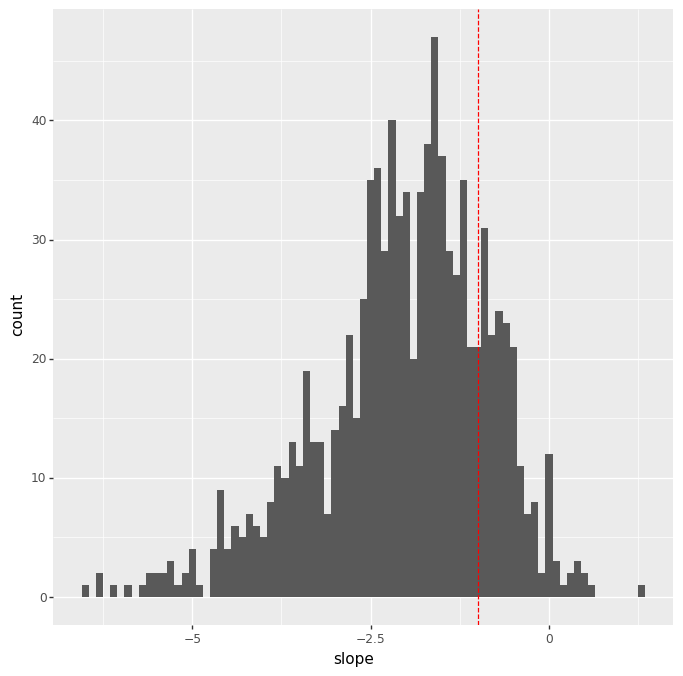

<ggplot: (-9223363258227473299)>


array([ 0.84380825,  0.16156181, -0.17082289, -0.88233308, -1.58818862,
       -2.23773478, -2.89152276, -3.20604122, -3.87835593])

In [204]:

print(p9.ggplot(df.query("Article == '675315'")) +  #178729
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )

np.quantile(df.query("Article == '178729'")['slope'],[0.99, 0.95, 0.90, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01])


Sampled article: 764981
norm
[('norm', 0.7134510877447774)]
{'norm': (-1.932199230887947, 0.8905340640569059)}


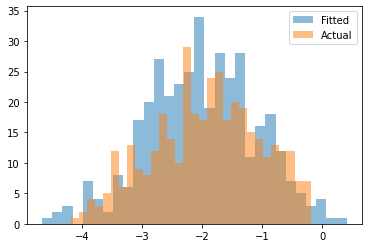

In [205]:
# determine best-fit distribution:
# https://www.hackdeploy.com/fitting-probability-distributions-with-python/
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm'] #['norm','lognorm','t', 'loggamma', 'gamma', 'dweibull']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted', bins=30)
        plt.hist(y, alpha=0.5, label='Actual', bins=30)
        plt.legend(loc='upper right')

from scipy.stats import norm
sample_article = df.query("(covid_flag == 'pre-covid')").Article.sample(1).iloc[0]
sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

# trim the highest and lowest 1% to avoid fitting to problematic data.
if(1):
  sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
  trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
  r = trimmed_sample_dat.slope
else:
  r = sample_dat.slope

dst = Distribution()
dst.Fit(r)
dst.Plot(r)

print("Sampled article:",sample_article)
print(dst.DistributionName)
print(dst.dist_results)
print(dst.params)

In [206]:
np.mean(trimmed_sample_dat.slope< (-1))

0.8355437665782494

In [207]:
# prob_fit_dict = {}
# for sample_article in df.Article.unique():
#   sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

#   try:
#   # trim the highest and lowest 1% to avoid fitting to problematic data.
#     if(1):
#       sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
#       trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
#       r = trimmed_sample_dat.slope
#     else:
#       r = sample_dat.slope
#     dst = Distribution()
#     dst.Fit(r)

#   #dst.Plot(r)
#     prob_fit_dict[sample_article] = {'Data':r, 'Dist':dst}
#   except:
#     pass

def dist_fit(df):
  prob_fit_dict = {}
  for sample_article in df.Article.unique():
    sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

    try:
    # trim the highest and lowest 1% to avoid fitting to problematic data.
      if(0):
        sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
        trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
        r = trimmed_sample_dat.slope
      else:
        r = sample_dat.slope
      dst = Distribution()
      dst.Fit(r)

    #dst.Plot(r)
      prob_fit_dict[sample_article] = {'Data':r, 'Dist':dst}
    except:
      pass
  
  return prob_fit_dict

prob_fit_dict = dist_fit(df)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[-0.589, 0.567]

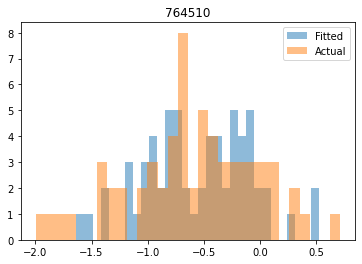

In [208]:
# view a random distribution fit
import random
sample_key = random.choice([x for x in prob_fit_dict.keys()])

prob_fit_dict[sample_key]['Dist'].Plot(prob_fit_dict[sample_key]['Data'])
plt.title(sample_key)
[round(x,3) for x in prob_fit_dict[sample_key]['Dist'].params['norm']]


In [209]:
for i in prob_fit_dict.keys():
  i_params = prob_fit_dict[i]['Dist'].params['norm']
  #prob_fit_dict[i]['prob_elastic'] = np.mean(np.random.normal(i_params[0],i_params[1],1000)<(-1))
  prob_fit_dict[i]['prob_elastic'] = scipy.stats.norm(i_params[0], i_params[1]).cdf(-1)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [210]:
model_df = pd.DataFrame({
    'Article':[i for i in prob_fit_dict.keys()],
    'Mean':[prob_fit_dict[i]['Dist'].params['norm'][0] for i in prob_fit_dict.keys()],
    'sd':[prob_fit_dict[i]['Dist'].params['norm'][1] for i in prob_fit_dict.keys()],
    'Prob_elastic':[prob_fit_dict[i]['prob_elastic'] for i in prob_fit_dict.keys()]
}).query("(sd != 0)")

# get past 12 months sales per article
past_12m_salesData = get_bq_data("""
    #standardSQL
    SELECT
    ifnull(Article,'') as Article,
    ifnull(Article_Description,'') as Article_Description,
    sum(Sales_ExclTax) as past12m_Sales_ExclTax
    FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
    WHERE
    SalesOrg in ('1005') AND
    Category_Description in ("MEAT","MEAT CONVENIENCE") AND
    Calendar_Day between DATE_SUB(CURRENT_DATE(), INTERVAL 364 DAY) and DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
    group by ifnull(Article,''),
    ifnull(Article_Description,'')
    """, project_id=project)

merged_model_df = model_df.merge(past_12m_salesData, 'inner', on='Article')


Downloading: 100%|██████████| 4901/4901 [00:01<00:00, 4272.88rows/s]


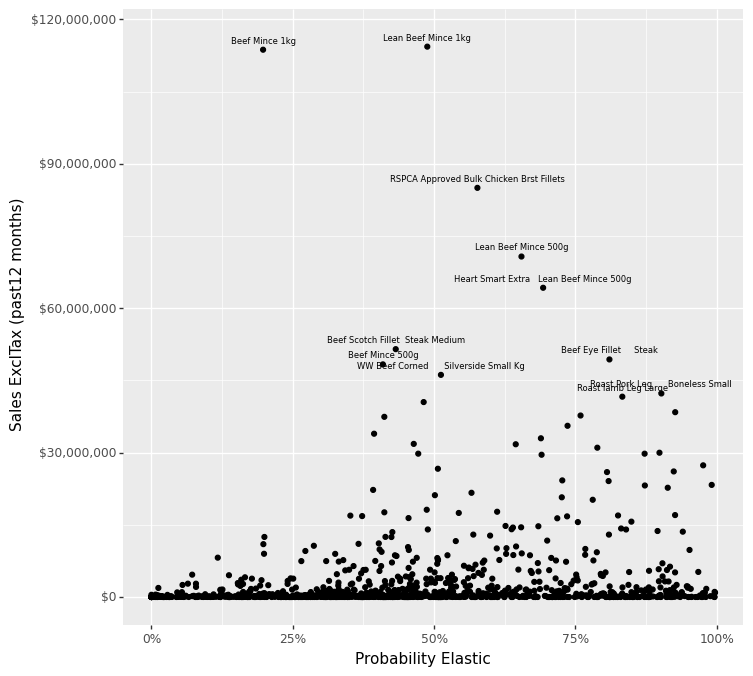

<ggplot: (8778625129115)>

In [211]:
p9.options.set_option("figure_size", (8, 8))
(p9.ggplot(merged_model_df) + 
 p9.aes(x='Prob_elastic', y='past12m_Sales_ExclTax') + 
 p9.geom_point() +
 p9.labs(x="Probability Elastic", y="Sales ExclTax (past12 months)") +
 p9.geom_text(label=np.where(merged_model_df.past12m_Sales_ExclTax > np.quantile(merged_model_df.past12m_Sales_ExclTax,0.99), merged_model_df.Article_Description, ""), 
              size=6, nudge_y=2000000) +
 p9.scale_y_continuous(labels=currency_format(big_mark=',', digits=0)) +
 p9.scale_x_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])
 )


In [212]:
merged_model_df.to_csv("meat_elasticity_model_summary.csv", index=False)

## Clustering

[44733.61, 21880.940170450784, 10724.962540583972, 6333.704605030237, 3361.080853508285, 2235.8243529637502, 1764.2132301798647, 1295.1588323596006, 904.0527882534849, 607.8325151453953, 475.28008985984013, 403.2577158250435, 334.67547271396114, 294.47630959826995, 264.2433750607424, 240.43296815755974, 212.07089937043025, 196.2153712426089, 181.8012538417334, 165.94572571391205]


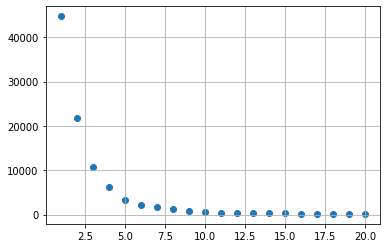

In [213]:
from sklearn.cluster import KMeans
import umap

def kmeans_diff_n(df,
                  n_clusters=[1],
                  max_iter=300,
                  tol=1e-04,
                  init='k-means++',
                  n_init=10,
                  algorithm='auto'):
    from sklearn.cluster import KMeans
    inertia_values = []
    for i in n_clusters:
        km = KMeans(n_clusters=i,
                    max_iter=max_iter,
                    tol=tol,
                    init=init,
                    n_init=n_init,
                    random_state=1,
                    algorithm=algorithm)
        km.fit_predict(df)
        inertia_values.append(km.inertia_)
    return inertia_values

df_wide = df.query("(covid_flag == 'pre-covid')").pivot(index="Site",
                   columns=["Article", "Sales_Unit"],
                   values="slope")

# drop column if all na's
df_wide = df_wide.dropna(axis=1, how='all')
# fill na with column medians
df_wide = df_wide.replace([np.inf, -np.inf], np.nan)
#df_wide = df_wide.apply(lambda x: x.fillna(x.median()))
df_wide = df_wide.apply(lambda x: x.fillna(0))
df_wide = df_wide.apply(lambda x: np.where(x < -10, -10, x))
df_wide = df_wide.apply(lambda x: np.where(x > 0, 0, x))

# find best number of clusters using elbow method:
embedding = umap.UMAP(n_neighbors=10, n_components=2).fit_transform(df_wide)

if (1):
    l_clusters = [
        x for x in np.array(range(1, min(21, df_wide.shape[0])))
        #if x == 1 or x % 3 == 0
    ]
    kmeans_var_explained = kmeans_diff_n(embedding, l_clusters)
    print(kmeans_var_explained)

plt.scatter(x=l_clusters, y=kmeans_var_explained)
plt.grid()


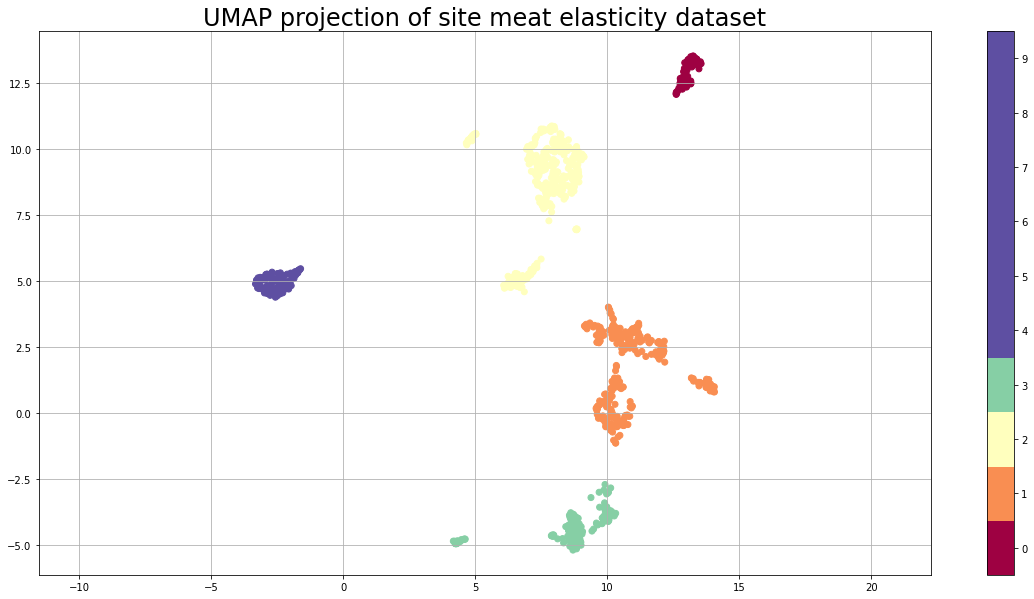

In [214]:

my_kmeans = KMeans(n_clusters=5, random_state=0).fit(embedding) #KMeans(n_clusters=5, random_state=0).fit(df_wide)

df_site_cluster_pair = pd.DataFrame({
    'site': list(df_wide.index),
    'cluster': list(my_kmeans.labels_)
})

plt.figure(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=my_kmeans.labels_, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of site meat elasticity dataset', fontsize=24);
plt.grid()


In [215]:
df_wide.head(3)

Article,100198,100292,100295,100297,100299,100360,100361,100373,100384,100394,100398,100419,100427,100449,100450,100453,100457,100462,100525,100528,100540,100590,100593,100596,100617,100749,100758,100765,100944,100983,101035,101036,101043,101063,101067,101076,101094,101103,101109,101111,...,943124,943224,946942,948244,948247,948269,951858,953307,954392,954488,954544,954547,954551,955488,958752,958757,958759,958761,958763,958808,964093,964833,964834,964835,964836,964837,964838,964840,964841,967114,969723,969724,970382,971384,971388,971389,972203,972206,972210,972212
Sales_Unit,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,...,EA,EA,EA,EA,EA,EA,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,EA,KG,EA,EA,KG,KG,KG,KG,KG,KG,EA,KG,KG,KG,KG,KG,KG,EA,EA,EA,EA
Site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.118571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.869061,-1.279613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.659202,-0.981554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## plot sales $ over elasticity

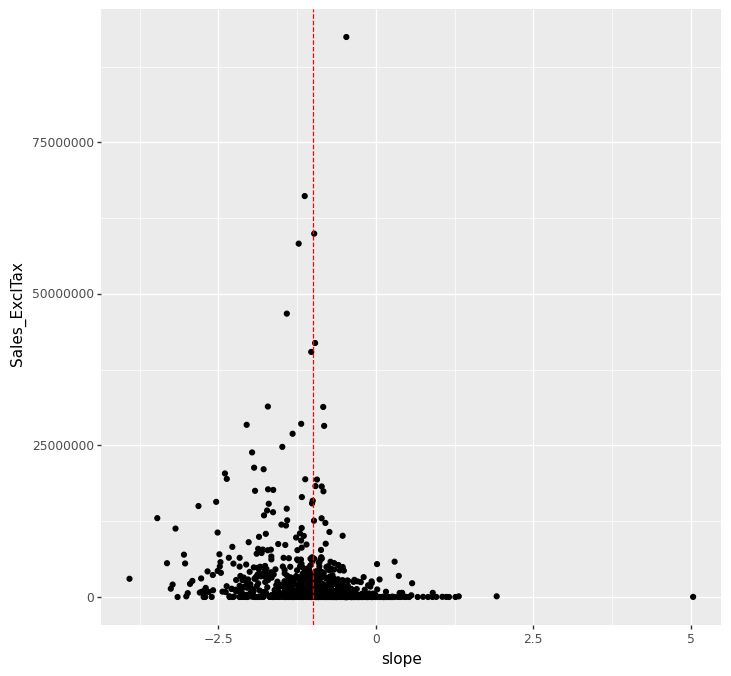

<ggplot: (8778623722525)>

In [216]:
#plotData = df.query("(covid_flag == 'pre-covid')").groupby('Article').agg({'Sales_ExclTax':'sum', 'slope':'mean'}).reset_index(name='Article')
plotData = df.query("(covid_flag == 'pre-covid')").groupby(['Article', 'Article_Description']).agg({'Sales_ExclTax':'sum', 'slope':'mean'}).reset_index()

(p9.ggplot(plotData) + 
 p9.aes(x='slope', y='Sales_ExclTax') + 
 p9.geom_point() +
 p9.labs(x="slope", y="Sales_ExclTax") +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )


In [217]:
plotData.sort_values('Sales_ExclTax', ascending=False)

,Article,Article_Description,Sales_ExclTax,slope
491,577864,Beef Mince 1kg,9.238101e+07,-0.468147
1169,964093,RSPCA Approved Bulk Chicken Brst Fillets,6.614247e+07,-1.128737
489,577862,Lean Beef Mince 1kg,5.994229e+07,-0.978060
488,577861,Lean Beef Mince 500g,5.829313e+07,-1.224429
487,577860,Heart Smart Extra Lean Beef Mince 500g,4.674735e+07,-1.413075
...,...,...,...,...
735,686047,Veneto Veal Osso Bucco,2.770800e+02,-0.774657
1085,821429,Pork Rashers,2.761200e+02,-1.802887
356,407307,Pork Scotch Fillet Thin Cut,2.655100e+02,-1.891350
1074,817176,Bruemar Pork Cutlet Lightly Infused 400g,2.599200e+02,-0.488838


In [218]:
df.columns

Index(['SalesOrg', 'Site', 'Article', 'Article_Description',
       'Category_Description', 'SubCategory_Description', 'Sales_Unit',
       'covid_flag', 'mean_x', 'mean_y', 'corr_xy', 'sd_x', 'sd_y',
       'cnt_overs', 'cnt_unders', 'perc_unders', 'Sales_ExclTax',
       'Sales_Qty_SUoM', 'ASP', 'slope', 'y_intercept', 'elasticity_score'],
      dtype='object')

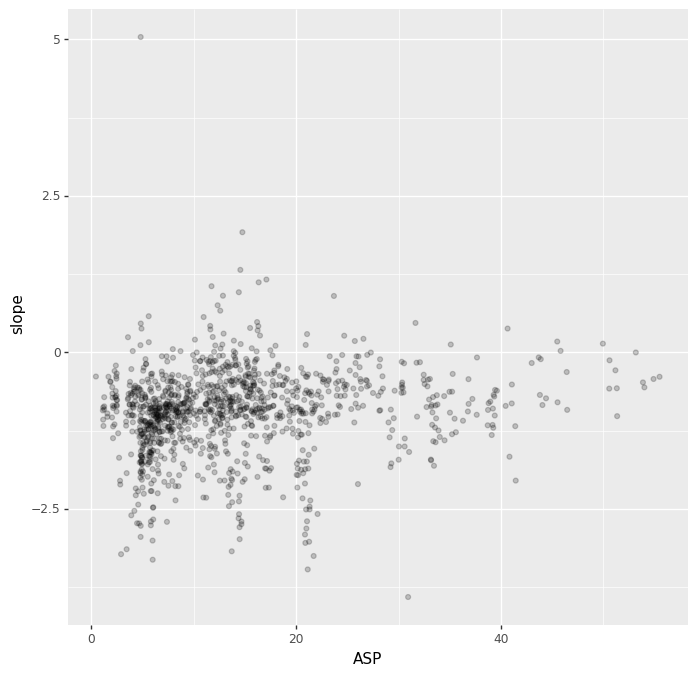

<ggplot: (8778625058543)>

In [219]:
plotData = df.query("(covid_flag == 'pre-covid')").groupby(['Article', 'Article_Description']).agg({'ASP':'mean', 'slope':'mean', 'Sales_ExclTax':'sum'}).reset_index().query("(Sales_ExclTax > 1000)")

(p9.ggplot(plotData) + 
 p9.aes(x='ASP', y='slope') + 
 p9.geom_point(alpha=0.2) +
 p9.labs(x="ASP", y="slope")
)


In [220]:
plotData

,Article,Article_Description,ASP,slope,Sales_ExclTax
0,100198,Gravy Beef kg 5,15.954946,-0.153962,220163.94
1,100292,Beef Porterhouse Steak kg 5,29.120794,-1.358916,1664286.76
2,100295,Beef Porterhouse Steak kg 2,29.375254,-1.243035,1962991.11
3,100297,Beef T Bone Steak kg 5,21.120184,-3.469046,13008384.81
4,100299,Beef T Bone Steak kg 2,21.176326,-1.857407,3868673.78
...,...,...,...,...,...
1184,971389,Beef Rib On Bone Whole,21.054647,0.290761,2221.56
1185,972203,Pure Black Beef Burgers 450g,7.637594,-0.863009,240167.43
1186,972206,Pure Black Beef Sausages 450g,7.492095,-1.064845,178657.12
1187,972210,Pure Black Beef Meatballs 420g,7.300747,-0.828695,78160.96


## Misc

In [221]:
print(df.shape)
df.head(3)

(271906, 22)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
0,1005,7014,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.015051,0.030251,0.161412,0.133498,0.846687,7,9,0.152542,2323.34,145.106,16.011330,1.023723,0.045659,-4701.796998
1,1005,5901,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.003911,0.010783,-0.087346,0.103685,0.857942,21,27,0.089701,21999.28,1350.977,16.283978,-0.722745,0.007956,-6099.404076
2,1005,7214,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.000577,-0.026451,0.006963,0.182274,0.753068,24,19,0.137681,3673.77,228.535,16.075306,0.028769,-0.026434,-3779.460296


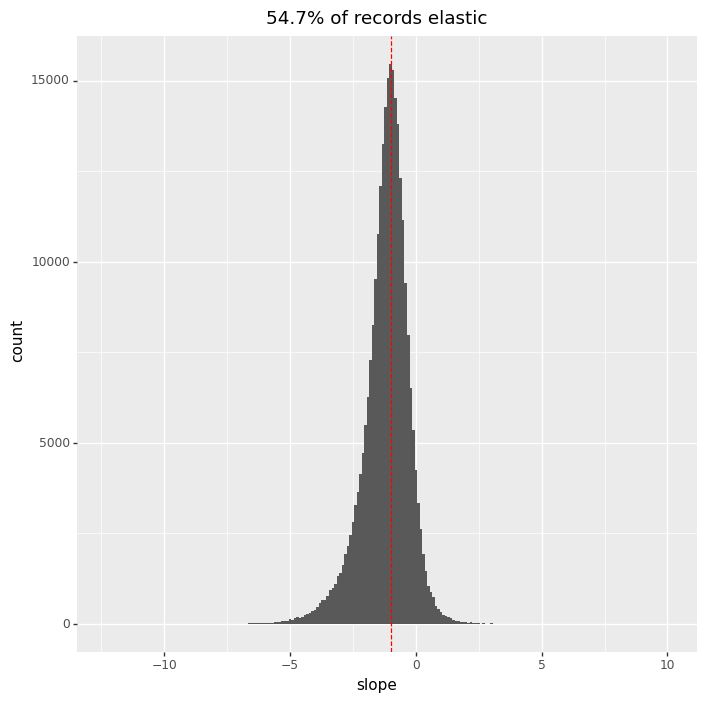

<ggplot: (-9223363258209844231)>

In [222]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df.query("(covid_flag == 'pre-covid')")) + 
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.labs(title=str(round(np.mean(df.slope < -1)*100,1))+"% of records elastic")
 )


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


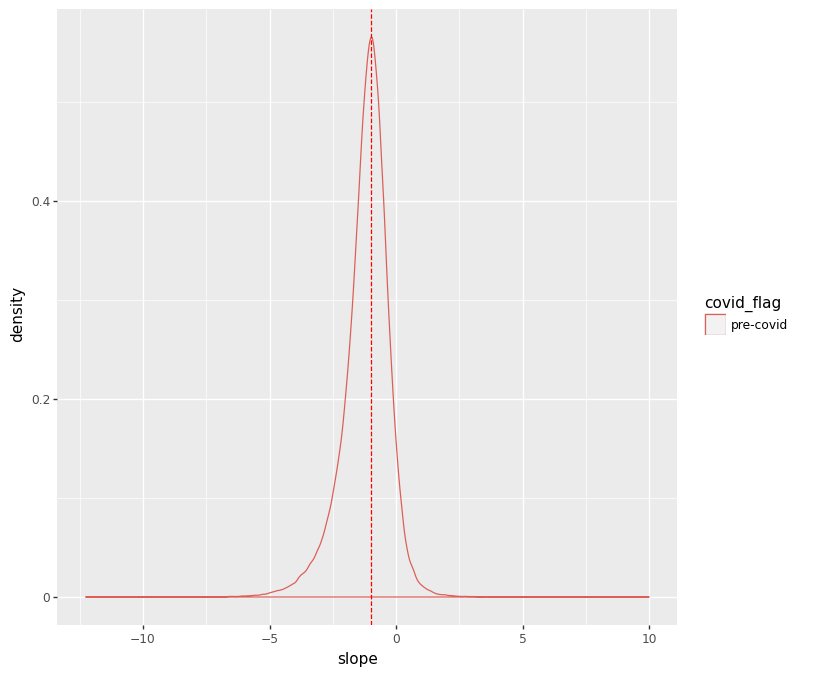

<ggplot: (8778625100138)>

In [223]:
# look at distribution of model slopes by covid period. Overall.
(p9.ggplot(df) + 
 p9.aes(x='slope', color='covid_flag') + 
 p9.geom_density() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )


In [224]:
# look at distribution of model slopes by covid period. Per article
covid_compare_article = df.pivot_table(index=['Article','Article_Description',	'Category_Description',	'SubCategory_Description',	'Sales_Unit'], columns='covid_flag', values='slope').dropna().reset_index()
covid_compare_article['pre_preCovidSlope_less_panicBuySlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (panic buying)']
covid_compare_article['pre_preCovidSlope_less_covidOtherSlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (Other)']

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_panicBuySlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_panicBuySlope")
 )

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_covidOtherSlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_covidOtherSlope")
 )

KeyError: ignored

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.6/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


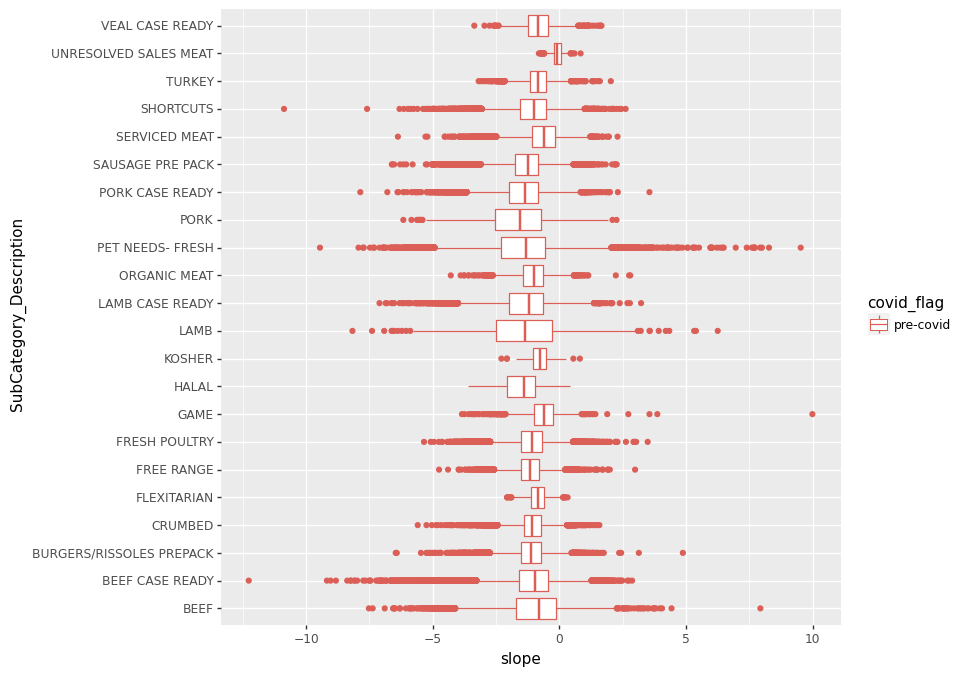

<ggplot: (8778628918883)>

In [226]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df) + 
 p9.aes(x='SubCategory_Description', y='slope', color='covid_flag') + 
 #p9.geom_histogram(binwidth=0.1) +
 p9.geom_boxplot() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.coord_flip() 
 )


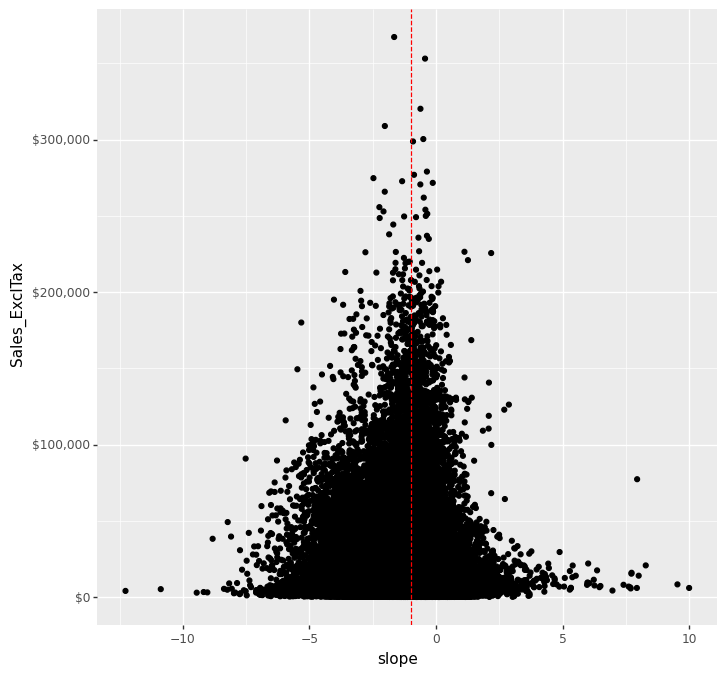

<ggplot: (8778627598035)>

In [227]:
# look at slopes against sales $s. The idea being that we should focus more attention of more popular products.
(p9.ggplot(df) + 
 p9.aes(x='slope', y='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.scale_y_continuous(labels=currency_format(big_mark=',', digits=0))
 )


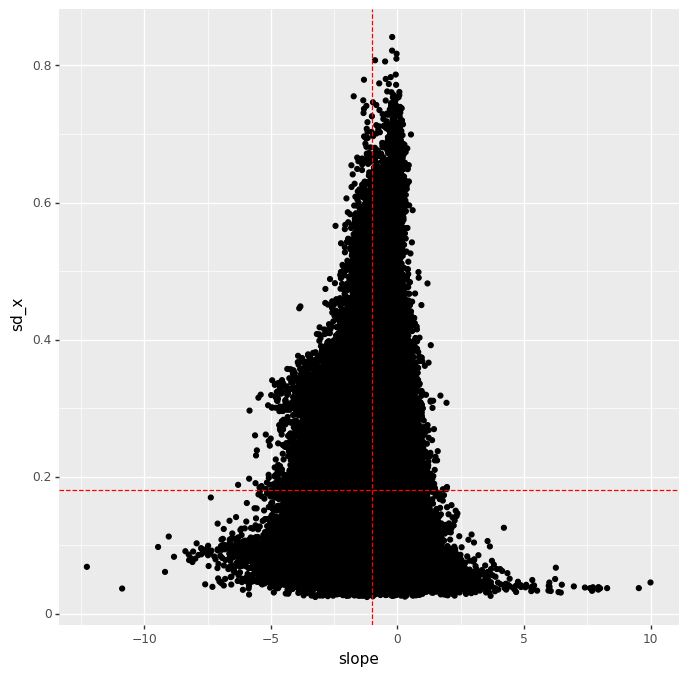

<ggplot: (-9223363258231587626)>

In [228]:
# Check if we are often moving prices on inelastic articles.
# look at price variations relative to slopes.

(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x') +#, color='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') #+
 #p9.scale_color_gradient2(low='White', mid='Gray', high='Red', midpoint=np.median(df.Sales_ExclTax))
 )


In [229]:
df.query("slope > -1").sort_values('Sales_ExclTax', ascending=False)

,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
1743,1005,5636,100540,Lamb Forequarter Chops Kg 5,MEAT,LAMB,KG,pre-covid,0.004153,0.010213,-0.065511,0.088660,0.589660,58,51,0.146974,353113.720,24723.127,14.282729,-0.435705,0.012022,-199260.178017
102304,1005,4324,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.005615,0.000476,-0.302083,0.131943,0.269476,28,20,0.065359,320223.580,41263.000,7.760550,-0.616963,0.003940,-122657.571468
102366,1005,2234,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.005038,-0.014846,-0.060625,0.046475,0.386653,17,8,0.023055,300347.350,38079.000,7.887480,-0.504376,-0.012305,-148859.324288
270973,1005,1767,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000274,-0.008842,-0.142500,0.052507,0.335499,18,20,0.056818,298787.890,33044.267,9.042049,-0.910513,-0.008592,-26737.725106
101732,1005,2687,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.005916,-0.004077,-0.068160,0.043719,0.232346,24,12,0.034582,279020.200,35298.000,7.904703,-0.362236,-0.001934,-177949.173603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83496,1005,2951,513258,Ngift Deli Dog Roll W/Beef And Veg 200g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,-0.010947,-0.055246,-0.201721,0.210644,0.825892,8,10,0.370370,48.304,40.000,1.207600,-0.790909,-0.063905,-10.099939
84240,1005,3137,513371,Ngift Deli Dog Roll W/Lamb And Veg 200g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,0.002145,-0.051344,-0.222925,0.175482,0.590601,8,8,0.296296,45.470,36.000,1.263056,-0.750279,-0.049735,-11.354826
84256,1005,2592,513371,Ngift Deli Dog Roll W/Lamb And Veg 200g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,0.052688,-0.031190,-0.142652,0.194094,0.571106,13,7,0.269231,44.062,35.000,1.258914,-0.419743,-0.009074,-25.567305
83975,1005,5317,513258,Ngift Deli Dog Roll W/Beef And Veg 200g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,0.008512,-0.020273,0.316060,0.208215,0.765995,9,8,0.400000,43.134,34.000,1.268647,1.162738,-0.030170,-93.287560


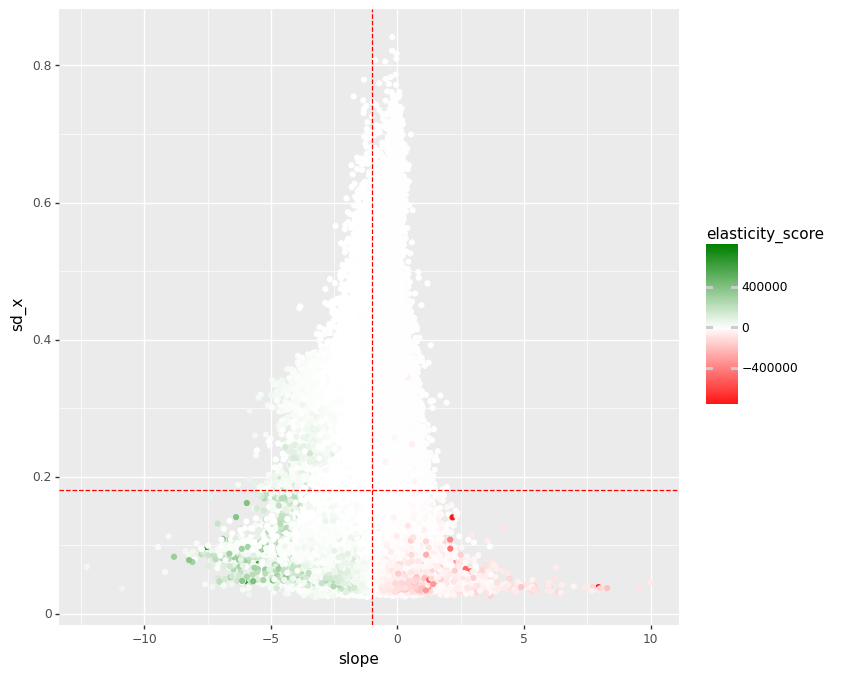

<ggplot: (-9223363258229358932)>


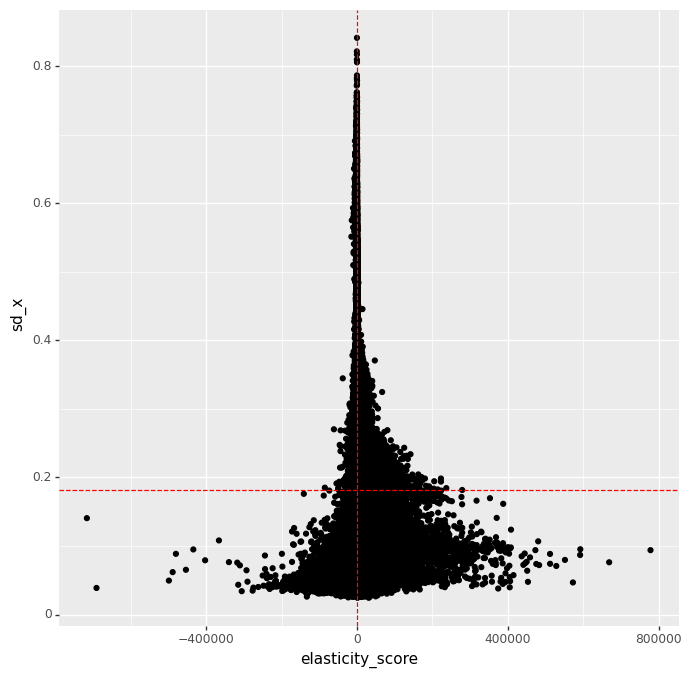

<ggplot: (8778623128584)>


In [230]:
print(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x', color='elasticity_score') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') +
 p9.scale_color_gradient2(low='Red', mid='White', high='Green', midpoint=np.median(df.elasticity_score))
 )

print(p9.ggplot(df) + 
 p9.aes(x='elasticity_score', y='sd_x') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= np.median(df.elasticity_score), color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed')
 )
